In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:


df = pd.read_csv('/content/SAMSUNG.csv')
df1=df.reset_index()['Close']

In [4]:
df1

0       77200
1       75900
2       78300
3       77700
4       78400
        ...  
1542    43800
1543    44450
1544    44000
1545    44250
1546    44850
Name: Close, Length: 1547, dtype: int64

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [10]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
18/18 [==============================] - 10s 216ms/step - loss: 0.0721 - val_loss: 0.0048
Epoch 2/100
18/18 [==============================] - 3s 182ms/step - loss: 0.0090 - val_loss: 0.0062
Epoch 3/100
18/18 [==============================] - 3s 181ms/step - loss: 0.0046 - val_loss: 0.0028
Epoch 4/100
18/18 [==============================] - 3s 146ms/step - loss: 0.0030 - val_loss: 7.8731e-04
Epoch 5/100
18/18 [==============================] - 3s 145ms/step - loss: 0.0027 - val_loss: 6.7047e-04
Epoch 6/100
18/18 [==============================] - 3s 148ms/step - loss: 0.0027 - val_loss: 7.2992e-04
Epoch 7/100
18/18 [==============================] - 4s 228ms/step - loss: 0.0025 - val_loss: 7.3088e-04
Epoch 8/100
18/18 [==============================] - 3s 146ms/step - loss: 0.0024 - val_loss: 7.2563e-04
Epoch 9/100
18/18 [==============================] - 3s 148ms/step - loss: 0.0023 - val_loss: 8.3238e-04
Epoch 10/100
18/18 [==============================] - 3s 145ms/ste

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 28ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [14]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 44854.62162913342
Testing RMSE: 50794.440399699924


In [15]:
x_input = val_data[60:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 30):

    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1


[0.06326525]
97
[0.06514245]
98
[0.06651352]
99
[0.06751785]
100
[0.06832688]
101
5 day input [0.10240964 0.10040161 0.0873494  0.07831325 0.06425703 0.08935743
 0.09638554 0.08433735 0.10140562 0.10843373 0.11646586 0.11646586
 0.1064257  0.09036145 0.08835341 0.08634538 0.09036145 0.09036145
 0.08634538 0.08333333 0.06325301 0.05421687 0.0562249  0.0562249
 0.05120482 0.06827309 0.07329317 0.07228916 0.06024096 0.05421687
 0.04518072 0.05220884 0.02610442 0.02710843 0.01204819 0.02710843
 0.02911647 0.03012048 0.05321285 0.04618474 0.03915663 0.01606426
 0.         0.00702811 0.02710843 0.02911647 0.02911647 0.03413655
 0.0251004  0.06124498 0.07329317 0.08232932 0.09437751 0.09337349
 0.09939759 0.07329317 0.06927711 0.07128514 0.08032129 0.08333333
 0.08232932 0.08835341 0.11746988 0.12148594 0.11746988 0.11345382
 0.10140562 0.11044177 0.10943775 0.10943775 0.11345382 0.11546185
 0.10843373 0.09136546 0.07730924 0.06927711 0.07329317 0.08333333
 0.0813253  0.08634538 0.10742972 0.

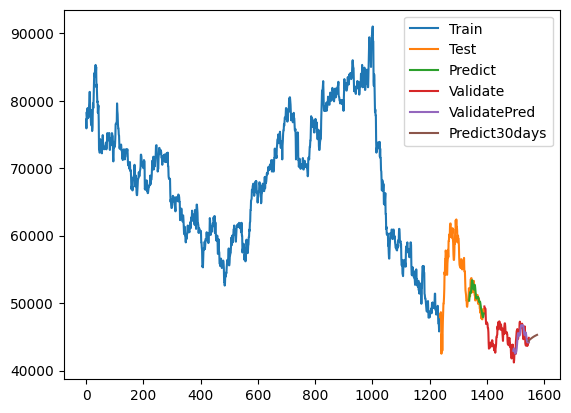

In [16]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [17]:
x_input = val_data[60:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 60):

    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1


[0.06326525]
97
[0.06514245]
98
[0.06651352]
99
[0.06751785]
100
[0.06832688]
101
5 day input [0.10240964 0.10040161 0.0873494  0.07831325 0.06425703 0.08935743
 0.09638554 0.08433735 0.10140562 0.10843373 0.11646586 0.11646586
 0.1064257  0.09036145 0.08835341 0.08634538 0.09036145 0.09036145
 0.08634538 0.08333333 0.06325301 0.05421687 0.0562249  0.0562249
 0.05120482 0.06827309 0.07329317 0.07228916 0.06024096 0.05421687
 0.04518072 0.05220884 0.02610442 0.02710843 0.01204819 0.02710843
 0.02911647 0.03012048 0.05321285 0.04618474 0.03915663 0.01606426
 0.         0.00702811 0.02710843 0.02911647 0.02911647 0.03413655
 0.0251004  0.06124498 0.07329317 0.08232932 0.09437751 0.09337349
 0.09939759 0.07329317 0.06927711 0.07128514 0.08032129 0.08333333
 0.08232932 0.08835341 0.11746988 0.12148594 0.11746988 0.11345382
 0.10140562 0.11044177 0.10943775 0.10943775 0.11345382 0.11546185
 0.10843373 0.09136546 0.07730924 0.06927711 0.07329317 0.08333333
 0.0813253  0.08634538 0.10742972 0.

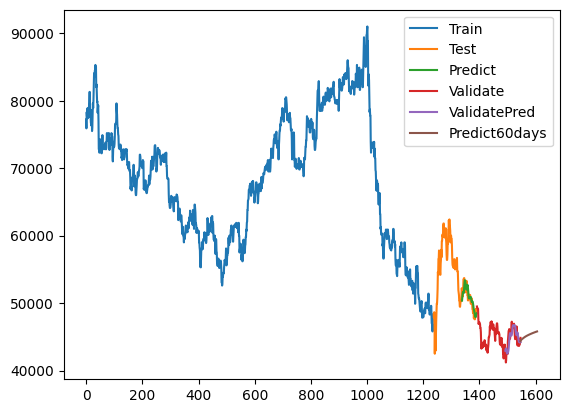

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả định các biến đã được định nghĩa trước đó:
# train_data, test_data, y_pred, val_data, y_pred_val, lst_output, scaler, df1
# Và các giá trị train_size, test_size, val_size đã được xác định

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred, label='Predict')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validate')

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, label='ValidatePred')

# Đảm bảo lst_output chứa dự đoán cho 60 ngày
if len(lst_output) == 60:
    predict_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
    plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Predict60days')
else:
    print(f"Expected lst_output to have 60 elements, but got {len(lst_output)}")

plt.legend()
plt.show()


In [19]:
x_input = val_data[60:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1


[0.06326525]
97
[0.06514245]
98
[0.06651352]
99
[0.06751785]
100
[0.06832688]
101
5 day input [0.10240964 0.10040161 0.0873494  0.07831325 0.06425703 0.08935743
 0.09638554 0.08433735 0.10140562 0.10843373 0.11646586 0.11646586
 0.1064257  0.09036145 0.08835341 0.08634538 0.09036145 0.09036145
 0.08634538 0.08333333 0.06325301 0.05421687 0.0562249  0.0562249
 0.05120482 0.06827309 0.07329317 0.07228916 0.06024096 0.05421687
 0.04518072 0.05220884 0.02610442 0.02710843 0.01204819 0.02710843
 0.02911647 0.03012048 0.05321285 0.04618474 0.03915663 0.01606426
 0.         0.00702811 0.02710843 0.02911647 0.02911647 0.03413655
 0.0251004  0.06124498 0.07329317 0.08232932 0.09437751 0.09337349
 0.09939759 0.07329317 0.06927711 0.07128514 0.08032129 0.08333333
 0.08232932 0.08835341 0.11746988 0.12148594 0.11746988 0.11345382
 0.10140562 0.11044177 0.10943775 0.10943775 0.11345382 0.11546185
 0.10843373 0.09136546 0.07730924 0.06927711 0.07329317 0.08333333
 0.0813253  0.08634538 0.10742972 0.

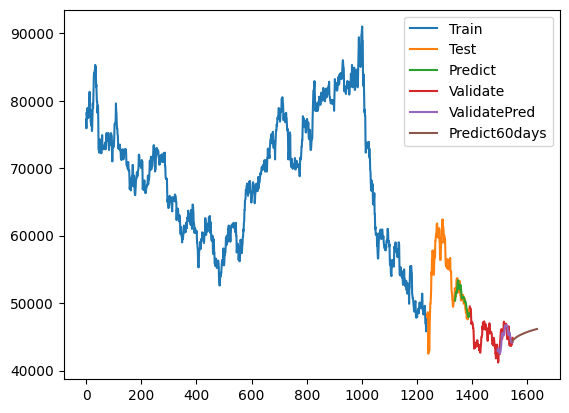

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả định các biến đã được định nghĩa trước đó:
# train_data, test_data, y_pred, val_data, y_pred_val, lst_output, scaler, df1
# Và các giá trị train_size, test_size, val_size đã được xác định

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred, label='Predict')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validate')

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, label='ValidatePred')

# Đảm bảo lst_output chứa dự đoán cho 60 ngày
if len(lst_output) == 90:
    predict_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
    plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Predict60days')
else:
    print(f"Expected lst_output to have 90 elements, but got {len(lst_output)}")

plt.legend()
plt.show()
